In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from collections import Counter

# 데이터 로드 및 탐색

In [2]:
data = pd.read_csv('C:/Users/송이두/Desktop/가천대/2-1/인공지능개론/과제/data/diabetes.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# 심각한 레이블 불균형을 띄고 있음.
data.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

# 데이터 스케일링

In [7]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

X.shape, y.shape

((768, 8), (768,))

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X[:1], X_scaled[:1]

(array([[  6.   , 148.   ,  72.   ,  35.   ,   0.   ,  33.6  ,   0.627,
          50.   ]]),
 array([[ 0.63994726,  0.84832379,  0.14964075,  0.90726993, -0.69289057,
          0.20401277,  0.46849198,  1.4259954 ]]))

# train, test 분리

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [34]:
#pytorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [35]:
#텐서 데이터셋 설정 및 데이터 로더 설정
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

# 모델 정의

In [52]:
class DiabetesClf(nn.Module):
    def __init__(self):
        super(DiabetesClf, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # binary clf

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesClf()

# 손실 함수 및 최적화 기법 정의

In [53]:
#레이블 불균형을 해결하기 위한 가중치 적용
class_counts = Counter(label.item() for label in y_train.flatten())
pos_weight = torch.tensor([class_counts[0] / class_counts[1]], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters())

# 모델 학습

In [54]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.float().unsqueeze(1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    threshold = 0.5  # 예측 임계값 설정
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (outputs >= threshold).float()  # 임계값 이상이면 1, 미만이면 0으로 예측
            total += labels.size(0)
            correct += (predicted == labels.float().unsqueeze(1)).sum().item() # 예측값과 실제 레이블 비교 (차원 맞추기)

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")
print("Training complete.")

Epoch 1/30, Loss: 0.8962, Accuracy: 64.94%
Epoch 2/30, Loss: 0.8495, Accuracy: 66.88%
Epoch 3/30, Loss: 0.7992, Accuracy: 74.03%
Epoch 4/30, Loss: 0.7193, Accuracy: 75.32%
Epoch 5/30, Loss: 0.7020, Accuracy: 75.97%
Epoch 6/30, Loss: 0.6735, Accuracy: 79.22%
Epoch 7/30, Loss: 0.6607, Accuracy: 80.52%
Epoch 8/30, Loss: 0.6442, Accuracy: 79.87%
Epoch 9/30, Loss: 0.6473, Accuracy: 80.52%
Epoch 10/30, Loss: 0.6428, Accuracy: 81.17%
Epoch 11/30, Loss: 0.6298, Accuracy: 82.47%
Epoch 12/30, Loss: 0.6484, Accuracy: 84.42%
Epoch 13/30, Loss: 0.6077, Accuracy: 83.77%
Epoch 14/30, Loss: 0.6283, Accuracy: 82.47%
Epoch 15/30, Loss: 0.6110, Accuracy: 83.12%
Epoch 16/30, Loss: 0.6019, Accuracy: 83.12%
Epoch 17/30, Loss: 0.6045, Accuracy: 82.47%
Epoch 18/30, Loss: 0.6040, Accuracy: 83.12%
Epoch 19/30, Loss: 0.6034, Accuracy: 83.12%
Epoch 20/30, Loss: 0.5902, Accuracy: 83.12%
Epoch 21/30, Loss: 0.5839, Accuracy: 84.42%
Epoch 22/30, Loss: 0.5698, Accuracy: 83.77%
Epoch 23/30, Loss: 0.5673, Accuracy: 83.1

# 모델 평가

In [55]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        # 이진 분류 출력을 확률로 변환
        probabilities = torch.sigmoid(outputs).squeeze(1)  # (batch_size, 1) -> (batch_size)
        # 임계값을 기준으로 예측 클래스 결정
        predicted = (probabilities >= 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='binary')  # 또는 'binary'
precision = precision_score(all_labels, all_predictions, average='binary')  # 또는 'binary'
recall = recall_score(all_labels, all_predictions, average='binary')  # 또는 'binary'

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[86 14]
 [12 42]]
F1 Score: 0.76
Precision: 0.75
Recall: 0.78


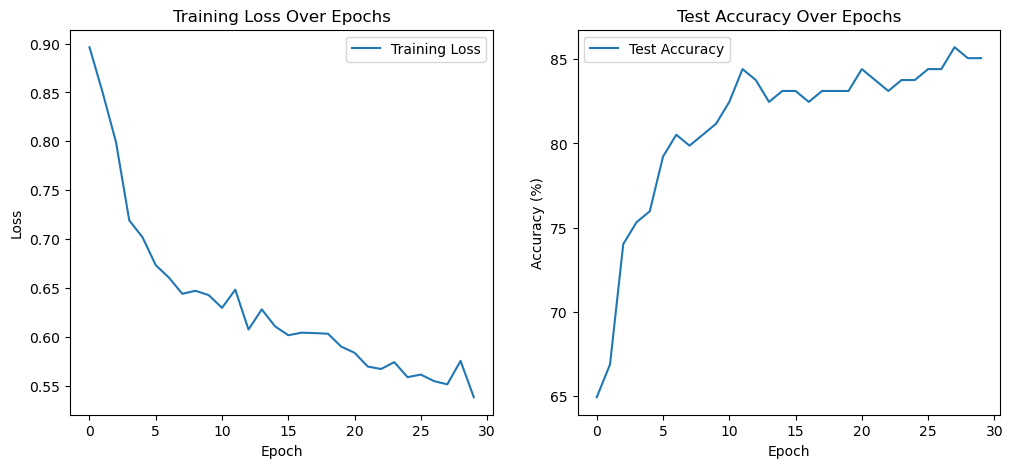

In [56]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()